In [36]:
# import the necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import config
from utils import imshow, show_plot
from contrastive import ContrastiveLoss
import torchvision
from torch.autograd import Variable
from PIL import Image
import PIL.ImageOps
import os
from tqdm import tqdm
import config

In [37]:
# load the dataset
training_dir = config.training_dir
testing_dir = config.testing_dir
training_csv = config.training_csv
testing_csv = config.testing_csv
val_csv = config.val_csv
val_dir = config.val_dir

In [38]:
# preprocessing and loading the dataset
class SiameseDataset:
    def __init__(self, training_csv=None, training_dir=None, transform=None):
        # used to prepare the labels and images path
        self.train_df = pd.read_csv(training_csv)
        self.train_df.columns = ["image1", "image2", "label"]
        self.train_dir = training_dir
        self.transform = transform

    def __getitem__(self, index):
        # getting the image path
        image1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
        image2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return (
            img0,
            img1,
            torch.from_numpy(
                np.array([int(self.train_df.iat[index, 2])], dtype=np.float32)
            ),
        )

    def __len__(self):
        return len(self.train_df)


In [39]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseDataset(
    training_csv,
    training_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

test_dataset = SiameseDataset(
    testing_csv,
    testing_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

eval_dataset = SiameseDataset(
    val_csv,
    val_dir,
    transform=transforms.Compose(
        [transforms.Resize((105, 105)), transforms.ToTensor()]
    ),
)

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        return output1, output2

In [42]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=config.batch_size)
eval_dataloader = DataLoader(eval_dataset, shuffle=True, batch_size=config.batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=config.batch_size)

# Declare Siamese Network
model = SiameseNetwork().to(device)
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0005)

In [43]:
# train the model
def train(model, device, optimizer, train_dataloader, epoch):
    model.train()
    cum_loss = 0
    
    for batch_idx, (images_1, images_2, targets) in enumerate(train_dataloader, 0):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        # output1, output2 = model(img0, img1)
        # loss_contrastive = criterion(output1, output2, label)
        # loss_contrastive.backward()
        output1, output2 = model(images_1, images_2)
        loss = criterion(output1, output2, targets)
        cum_loss += loss
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss))

def eval(model, device, eval_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for (images_1, images_2, targets) in eval_dataloader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            output1, output2 = model(images_1, images_2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            pred = torch.where(euclidean_distance > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(eval_dataloader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(eval_dataloader.dataset),
        100. * correct / len(eval_dataloader.dataset)))


In [44]:
eval(model, device, eval_dataloader)
for epoch in tqdm(range(1, config.epochs)):
    best_eval_loss = 9999
    train(model, device, optimizer, train_dataloader, epoch)
    eval(model, device, eval_dataloader)
    print("-" * 20)
    
    # if eval_loss < best_eval_loss:
    #     best_eval_loss = eval_loss
    #     print("-" * 20)
    #     print(f"Best Eval loss{best_eval_loss}")
    #     torch.save(net.state_dict(), "/content/model.pth")
    #     print("Model Saved Successfully")



Test set: Average loss: 0.0000, Accuracy: 1104/1820 (61%)



  0%|          | 0/19 [00:00<?, ?it/s]

Train Epoch: 1 [1568/5458 (29%)]	Loss: 0.072452
Train Epoch: 1 [3168/5458 (58%)]	Loss: 0.069122
Train Epoch: 1 [4768/5458 (87%)]	Loss: 0.101995


  5%|▌         | 1/19 [00:17<05:23, 17.98s/it]


Test set: Average loss: 0.0000, Accuracy: 1666/1820 (92%)

--------------------
Train Epoch: 2 [1568/5458 (29%)]	Loss: 0.086297
Train Epoch: 2 [3168/5458 (58%)]	Loss: 0.067750
Train Epoch: 2 [4768/5458 (87%)]	Loss: 0.088446


 11%|█         | 2/19 [01:09<10:36, 37.44s/it]


Test set: Average loss: 0.0000, Accuracy: 1726/1820 (95%)

--------------------
Train Epoch: 3 [1568/5458 (29%)]	Loss: 0.057359
Train Epoch: 3 [3168/5458 (58%)]	Loss: 0.028670
Train Epoch: 3 [4768/5458 (87%)]	Loss: 0.036756


 16%|█▌        | 3/19 [01:53<10:50, 40.63s/it]


Test set: Average loss: 0.0000, Accuracy: 1714/1820 (94%)

--------------------
Train Epoch: 4 [1568/5458 (29%)]	Loss: 0.054545
Train Epoch: 4 [3168/5458 (58%)]	Loss: 0.019724
Train Epoch: 4 [4768/5458 (87%)]	Loss: 0.074987


 21%|██        | 4/19 [02:17<08:30, 34.01s/it]


Test set: Average loss: 0.0000, Accuracy: 1717/1820 (94%)

--------------------
Train Epoch: 5 [1568/5458 (29%)]	Loss: 0.030656
Train Epoch: 5 [3168/5458 (58%)]	Loss: 0.069010
Train Epoch: 5 [4768/5458 (87%)]	Loss: 0.048437


 26%|██▋       | 5/19 [02:45<07:26, 31.90s/it]


Test set: Average loss: 0.0000, Accuracy: 1671/1820 (92%)

--------------------
Train Epoch: 6 [1568/5458 (29%)]	Loss: 0.071906
Train Epoch: 6 [3168/5458 (58%)]	Loss: 0.053173
Train Epoch: 6 [4768/5458 (87%)]	Loss: 0.037351


 32%|███▏      | 6/19 [03:09<06:19, 29.16s/it]


Test set: Average loss: 0.0000, Accuracy: 1726/1820 (95%)

--------------------
Train Epoch: 7 [1568/5458 (29%)]	Loss: 0.016269
Train Epoch: 7 [3168/5458 (58%)]	Loss: 0.054442
Train Epoch: 7 [4768/5458 (87%)]	Loss: 0.015923


 37%|███▋      | 7/19 [03:45<06:16, 31.42s/it]


Test set: Average loss: 0.0000, Accuracy: 1718/1820 (94%)

--------------------
Train Epoch: 8 [1568/5458 (29%)]	Loss: 0.032117
Train Epoch: 8 [3168/5458 (58%)]	Loss: 0.072583
Train Epoch: 8 [4768/5458 (87%)]	Loss: 0.058322


 42%|████▏     | 8/19 [04:05<05:05, 27.81s/it]


Test set: Average loss: 0.0000, Accuracy: 1715/1820 (94%)

--------------------
Train Epoch: 9 [1568/5458 (29%)]	Loss: 0.027623
Train Epoch: 9 [3168/5458 (58%)]	Loss: 0.022375
Train Epoch: 9 [4768/5458 (87%)]	Loss: 0.015387


 47%|████▋     | 9/19 [04:18<03:53, 23.30s/it]


Test set: Average loss: 0.0000, Accuracy: 1717/1820 (94%)

--------------------
Train Epoch: 10 [1568/5458 (29%)]	Loss: 0.021917
Train Epoch: 10 [3168/5458 (58%)]	Loss: 0.048330
Train Epoch: 10 [4768/5458 (87%)]	Loss: 0.023894


 53%|█████▎    | 10/19 [04:34<03:09, 21.06s/it]


Test set: Average loss: 0.0000, Accuracy: 1686/1820 (93%)

--------------------
Train Epoch: 11 [1568/5458 (29%)]	Loss: 0.044968
Train Epoch: 11 [3168/5458 (58%)]	Loss: 0.035603
Train Epoch: 11 [4768/5458 (87%)]	Loss: 0.057247


 58%|█████▊    | 11/19 [04:48<02:29, 18.72s/it]


Test set: Average loss: 0.0000, Accuracy: 1748/1820 (96%)

--------------------
Train Epoch: 12 [1568/5458 (29%)]	Loss: 0.051334
Train Epoch: 12 [3168/5458 (58%)]	Loss: 0.098628
Train Epoch: 12 [4768/5458 (87%)]	Loss: 0.070482


 63%|██████▎   | 12/19 [05:02<02:00, 17.25s/it]


Test set: Average loss: 0.0000, Accuracy: 1631/1820 (90%)

--------------------
Train Epoch: 13 [1568/5458 (29%)]	Loss: 0.036388
Train Epoch: 13 [3168/5458 (58%)]	Loss: 0.049407
Train Epoch: 13 [4768/5458 (87%)]	Loss: 0.016907


 68%|██████▊   | 13/19 [05:17<01:39, 16.56s/it]


Test set: Average loss: 0.0000, Accuracy: 1685/1820 (93%)

--------------------
Train Epoch: 14 [1568/5458 (29%)]	Loss: 0.040265
Train Epoch: 14 [3168/5458 (58%)]	Loss: 0.052865
Train Epoch: 14 [4768/5458 (87%)]	Loss: 0.019234


 74%|███████▎  | 14/19 [05:31<01:20, 16.03s/it]


Test set: Average loss: 0.0000, Accuracy: 1650/1820 (91%)

--------------------
Train Epoch: 15 [1568/5458 (29%)]	Loss: 0.031032
Train Epoch: 15 [3168/5458 (58%)]	Loss: 0.021527
Train Epoch: 15 [4768/5458 (87%)]	Loss: 0.050724


 79%|███████▉  | 15/19 [05:47<01:04, 16.03s/it]


Test set: Average loss: 0.0000, Accuracy: 1716/1820 (94%)

--------------------
Train Epoch: 16 [1568/5458 (29%)]	Loss: 0.011083
Train Epoch: 16 [3168/5458 (58%)]	Loss: 0.042378
Train Epoch: 16 [4768/5458 (87%)]	Loss: 0.047344


 84%|████████▍ | 16/19 [06:08<00:52, 17.39s/it]


Test set: Average loss: 0.0000, Accuracy: 1710/1820 (94%)

--------------------
Train Epoch: 17 [1568/5458 (29%)]	Loss: 0.046431
Train Epoch: 17 [3168/5458 (58%)]	Loss: 0.023450
Train Epoch: 17 [4768/5458 (87%)]	Loss: 0.065710


 89%|████████▉ | 17/19 [06:23<00:33, 16.79s/it]


Test set: Average loss: 0.0000, Accuracy: 1711/1820 (94%)

--------------------
Train Epoch: 18 [1568/5458 (29%)]	Loss: 0.036995
Train Epoch: 18 [3168/5458 (58%)]	Loss: 0.088294
Train Epoch: 18 [4768/5458 (87%)]	Loss: 0.030817


 95%|█████████▍| 18/19 [06:39<00:16, 16.33s/it]


Test set: Average loss: 0.0000, Accuracy: 1705/1820 (94%)

--------------------
Train Epoch: 19 [1568/5458 (29%)]	Loss: 0.023383
Train Epoch: 19 [3168/5458 (58%)]	Loss: 0.052596
Train Epoch: 19 [4768/5458 (87%)]	Loss: 0.045062


100%|██████████| 19/19 [07:00<00:00, 22.11s/it]


Test set: Average loss: 0.0000, Accuracy: 1703/1820 (94%)

--------------------


In [51]:
model.eval()
test_loss = 0
correct = 0
    
with torch.no_grad():
        for (images_1, images_2, targets) in test_dataloader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            output1, output2 = model(images_1, images_2)
            euclidean_distance = F.pairwise_distance(output1, output2)
            pred = torch.where(euclidean_distance > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))


Test set: Average loss: 0.0000, Accuracy: 1740/1820 (96%)



In [52]:
# Viewing the sample of images and to check whether its loading properly
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=8)
dataiter = iter(test_dataloader)

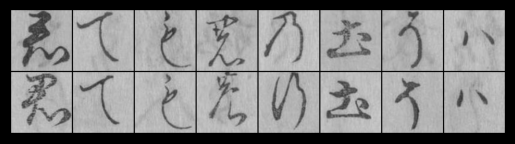

[[1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]]


In [53]:
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [54]:
images_1, images_2, targets = example_batch[0], example_batch[1], example_batch[2]
images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
output1, output2 = model(images_1, images_2)
euclidean_distance = F.pairwise_distance(output1, output2)
pred = torch.where(euclidean_distance > 0.5, 1, 0)  # get the index of the max log-probability

In [55]:
euclidean_distance

tensor([1.5400, 0.1231, 0.2166, 1.2534, 0.9874, 1.7099, 0.6917, 0.0492],
       device='cuda:0', grad_fn=<NormBackward1>)

In [56]:
pred

tensor([1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')